In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

In [ ]:
import dask.dataframe as dd
import pandas as pd
import os

folder_path = '/content/drive/MyDrive/parquet_stations'
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.parquet')]

daily_dfs = []

for file in all_files:
    # Đọc bằng Pandas
    df = pd.read_parquet(file)

    # Drop các cột không cần thiết sớm để tiết kiệm RAM/tính toán
    df = df.drop(columns=['WND_ANGLE', 'WND_RATE', 'SLP', 'MASK', 'TIME_DIFF'], errors='ignore')

    # Chuyển DATE về datetime
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.set_index('DATE')

    # Resample theo ngày: trung bình
    daily_df = df.resample('1D').mean().reset_index()

    # Giữ lại LONGITUDE & LATITUDE của trạm
    if 'LONGITUDE' in df.columns and 'LATITUDE' in df.columns:
        lon = df['LONGITUDE'].iloc[0]
        lat = df['LATITUDE'].iloc[0]
        daily_df['LONGITUDE'] = lon
        daily_df['LATITUDE'] = lat

    daily_dfs.append(daily_df)

# Gộp tất cả lại thành một Dask dataframe
combined_df = dd.from_pandas(pd.concat(daily_dfs, ignore_index=True), npartitions=4)

# Kiểm tra
print(combined_df.head())


        DATE  LONGITUDE   LATITUDE       TMP       DEW
0 2014-01-01  27.183333  60.283333  2.997917  1.397917
1 2014-01-02  27.183333  60.283333  0.483333 -1.475000
2 2014-01-03  27.183333  60.283333  0.991667 -0.804167
3 2014-01-04  27.183333  60.283333  2.212500  1.012500
4 2014-01-05  27.183333  60.283333  4.025000  3.395833


In [ ]:
station_features = combined_df.groupby(['LONGITUDE', 'LATITUDE']).agg({
    'TMP': ['mean', 'std'],
    'DEW': ['mean', 'std'],
}).compute().reset_index()

station_features.columns = ['LONGITUDE', 'LATITUDE', 'TMP_mean', 'TMP_std', 'DEW_mean', 'DEW_std']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = station_features[['TMP_mean', 'TMP_std']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
station_features['cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
combined_df = combined_df.merge(station_features[['LONGITUDE', 'LATITUDE', 'cluster']],
                                on=['LONGITUDE', 'LATITUDE'], how='left')

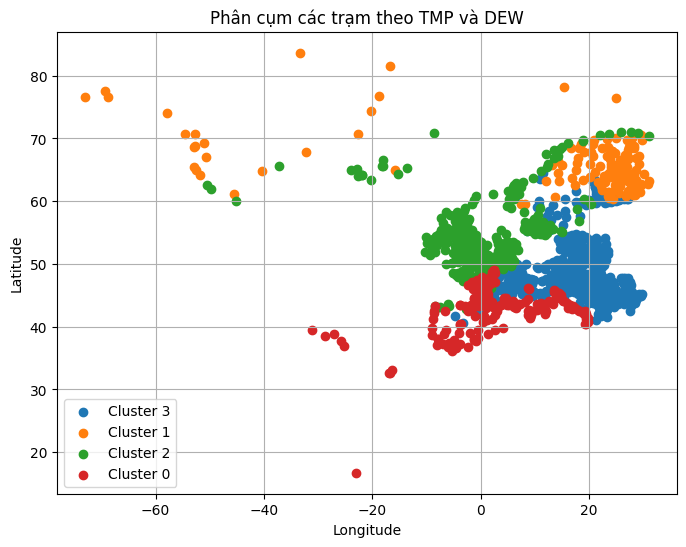

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for c in station_features['cluster'].unique():
    cluster_data = station_features[station_features['cluster'] == c]
    plt.scatter(cluster_data['LONGITUDE'], cluster_data['LATITUDE'], label=f'Cluster {c}')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Phân cụm các trạm theo TMP và DEW")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df = combined_df.compute()

In [ ]:
df

,DATE,LONGITUDE,LATITUDE,TMP,DEW,cluster
0,2014-01-01,27.183333,60.283333,2.997917,1.397917,3
1,2014-01-02,27.183333,60.283333,0.483333,-1.475000,3
2,2014-01-03,27.183333,60.283333,0.991667,-0.804167,3
3,2014-01-04,27.183333,60.283333,2.212500,1.012500,3
4,2014-01-05,27.183333,60.283333,4.025000,3.395833,3
...,...,...,...,...,...,...
1095595,2023-12-27,28.144397,61.044553,-11.595833,-12.916667,1
1095596,2023-12-28,28.144397,61.044553,-6.400000,-7.262500,1
1095597,2023-12-29,28.144397,61.044553,-4.283333,-4.950000,1
1095598,2023-12-30,28.144397,61.044553,-7.904167,-9.200000,1


In [ ]:
station_features[['LONGITUDE', 'LATITUDE', 'cluster']].drop_duplicates().dropna(subset=['LONGITUDE', 'LATITUDE']).to_csv('station_data.csv', index=False)